# КОМП’ЮТЕРНИЙ ПРАКТИКУМ №1

## ПЕРЕВІРКА ГЕНЕРАТОРА ВИПАДКОВИХ ЧИСЕЛ НА ВІДПОВІДНІСТЬ ЗАКОНУ РОЗПОДІЛУ

## Кочев Геннадій ІП-91

## Залежності

In [29]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Вивід на екран - форматування

In [30]:
def build_histogram(data, bins, title, color='blue'):
    _, ax = plt.subplots(figsize=(8, 6))

    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

    ax.grid(True)
    ax.hist(data, bins=bins, color=color)
    return ax

def format_statistics_info(data, title):
    mean, std = data
    return f'{title}: \nMean: {mean:.3f}, Std: {std:.3f}'

def format_chi_square_info(chi2, chi2_k, title):
    return f'{title}: \nChi^2: {chi2:.3f}, Chi^2 k: {chi2_k}'

## Обчислення значень

In [31]:
# How many columns will fit the histogram
def sturges_bins_amount(items_amt):
    return math.ceil(math.log2(items_amt) + 1)

# Create bins (sections borders on histogram) pairs
def split_bins(bins):
    return [(bins[idx - 1], bins[idx]) for idx in range(1, bins.size)]

def calculate_mean_std(items):
    mean = np.mean(items)
    std = np.std(items, ddof=1)
    return (mean, std)

# Chi2 from table (pre-defined) (Percent point function - ppf)
def calculate_chi2_k(alpha, bins_amt, params_amt):
    return stats.chi2.ppf(1 - alpha, bins_amt - params_amt - 1)

# Chi2 calculated by formula
def calculate_chi2(items_amt, values, bins, compute_step, *args):
    bins_pairs = split_bins(bins)
    probabilities_expected = np.array(
        [compute_step(left, right, *args) for left, right in bins_pairs]
    )
    values_expected = items_amt * probabilities_expected
    chi2 = np.sum(np.square(values - values_expected) / values_expected)
    return chi2

def is_matching_chi2_law(chi2, chi2_k):
    return chi2 <= chi2_k

# Експоненційний закон розподілу

## Конфігурація графіку гістограми

In [32]:
numbers_to_generate = 10000
exponential_bins = sturges_bins_amount(numbers_to_generate)
print('Bins for histogram Exponential:', exponential_bins)

Bins for histogram Exponential: 15


## Формулюємо закон розподілу

In [33]:
lambda_value = 4
xi = np.random.uniform(size=numbers_to_generate)
exponential_law = -1 / lambda_value * np.log(xi)
exponential_law

array([0.07526001, 0.3511128 , 0.7640748 , ..., 0.11692011, 0.06207179,
       0.08112587])

## Будуємо графік для перевірки закону

<AxesSubplot:title={'center':'Law - Exponential'}, xlabel='Value', ylabel='Frequency'>

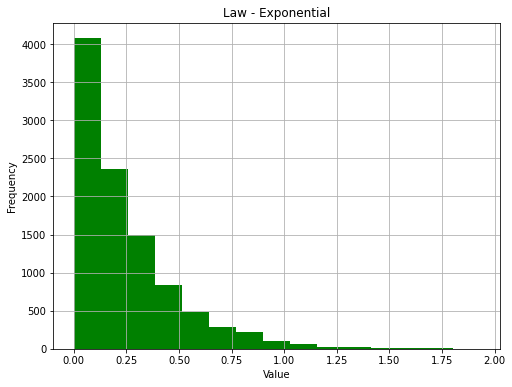

In [34]:
counts, bins = np.histogram(exponential_law, bins=exponential_bins)
build_histogram(exponential_law, exponential_bins, title='Law - Exponential', color='green')

## Статистика за законом

In [35]:
exponential_stats = calculate_mean_std(exponential_law)
exponential_mean, exponential_std = exponential_stats
fmt = format_statistics_info(exponential_stats, 'Exponential')
print(fmt)

Exponential: 
Mean: 0.246, Std: 0.244


## Перевірка за критерієм згоди xi^2

In [36]:
def calculate_exponential_step(left, right, lambda_value):
    return np.exp(-lambda_value * left) - np.exp(-lambda_value * right)

lambda_expected = 1 / exponential_mean
exponential_chi2 = calculate_chi2(numbers_to_generate, counts, bins, 
                                calculate_exponential_step, lambda_expected)
exponential_chi2_k = calculate_chi2_k(0.05, exponential_bins, 1)
fmt = format_chi_square_info(exponential_chi2, exponential_chi2_k, 'Exponential')
print(fmt)

Exponential: 
Chi^2: 19.911, Chi^2 k: 22.362032494826934


In [37]:
print('Exponential law works:', is_matching_chi2_law(exponential_chi2, exponential_chi2_k))

Exponential law works: True


# Нормальний закон розподілу

## Конфігурація графіку гістограми

In [39]:
numbers_to_generate = 10000
normal_init_bins = sturges_bins_amount(numbers_to_generate)
print('Bins for histogram Normal:', exponential_bins)

Bins for histogram Normal: 15


## Формулюємо закон розподілу

In [41]:
sigma_value = 4
a_value = -5

normal_law = np.zeros(numbers_to_generate)
for idx in range(numbers_to_generate):
    mu_value = np.random.uniform(size=12).sum() - 6
    normal_law[idx] = sigma_value * mu_value + a_value
normal_law

array([ -2.95763349, -11.54148904,  -9.11694328, ...,  -7.82786165,
        -9.4111833 ,   0.63560975])

## Будуємо графік для перевірки закону

<AxesSubplot:title={'center':'Law - Normal'}, xlabel='Value', ylabel='Frequency'>

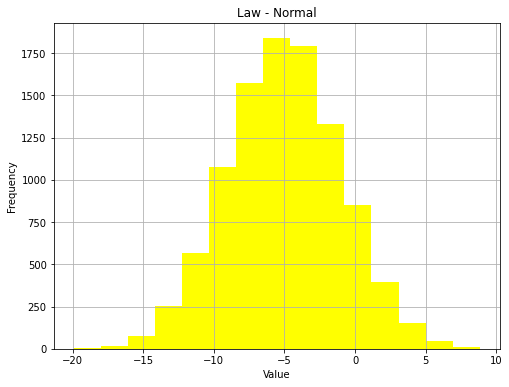

In [42]:
normal_counts, normal_bins = np.histogram(normal_law, bins=normal_init_bins)
build_histogram(normal_law, normal_bins, title='Law - Normal', color='yellow')

## Статистика за законом

In [43]:
normal_stats = calculate_mean_std(normal_law)
normal_mean, normal_std = normal_stats
fmt = format_statistics_info(normal_stats, 'Normal')
print(fmt)

Normal: 
Mean: -5.019, Std: 3.997


## Перевірка за критерієм згоди xi^2

In [44]:
# Cumulative distribution function - cdf
def calculate_normal_step(left, right, sigma_value, a_value):
    left_cdf, right_cdf = stats.norm.cdf([left, right], loc=sigma_value, scale=a_value)
    return right_cdf - left_cdf

sigma_expected = normal_mean
normal_expected = normal_std
normal_chi2 = calculate_chi2(numbers_to_generate, normal_counts, normal_bins, 
                            calculate_normal_step, sigma_expected, normal_expected)
normal_chi2_k = calculate_chi2_k(0.05, normal_init_bins, 2)
fmt = format_chi_square_info(normal_chi2, normal_chi2_k, 'Normal')
print(fmt)

Normal: 
Chi^2: 5.681, Chi^2 k: 21.02606981748307


In [45]:
print('Normal Law works:', is_matching_chi2_law(normal_chi2, normal_chi2_k))

Normal Law works: True


# Рівномірний закон розподілу

## Конфігурація графіку гістограми

In [46]:
numbers_to_generate = 10000
uniform_init_bins = sturges_bins_amount(numbers_to_generate)
print('Bins for Uniform Law:', uniform_init_bins)

Bins for Uniform Law: 15


## Формулюємо закон розподілу

In [49]:
a_value = 5**13
c_value = 2**31
zi_value = np.random.uniform()

uniform_law = np.zeros(numbers_to_generate)
for idx in range(numbers_to_generate):
    zi_value = (a_value * zi_value) % c_value
    uniform_law[idx] = zi_value / c_value
uniform_law


array([0.06121034, 0.08354937, 0.43709473, ..., 0.80477715, 0.30095482,
       0.70213127])

## Будуємо графік для перевірки закону

<AxesSubplot:title={'center':'Law - Uniform'}, xlabel='Value', ylabel='Frequency'>

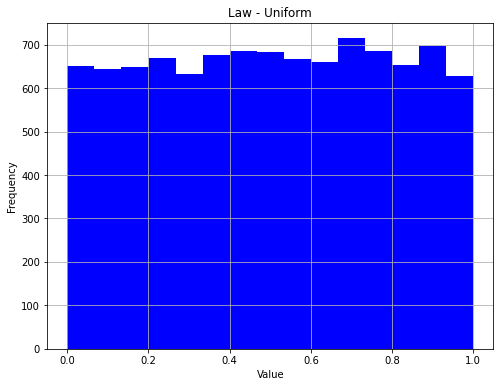

In [50]:
uniform_counts, uniform_bins = np.histogram(uniform_law, bins=uniform_init_bins)
build_histogram(uniform_law, uniform_bins, title='Law - Uniform', color='blue')

## Статистика за законом

In [51]:
uniform_stats = calculate_mean_std(uniform_law)
uniform_mean, uniform_std = uniform_stats
fmt = format_statistics_info(uniform_stats, 'Uniform')
print(fmt)

Uniform: 
Mean: 0.503, Std: 0.286


## Перевірка за критерієм згоди xi^2

In [53]:
def calculate_uniform_step(left, right, a_value, c_value):
    return (right - left) / (c_value - a_value)

a_expected = uniform_mean - 3 ** 0.5 * uniform_std
c_expected = uniform_mean + 3 ** 0.5 * uniform_std
uniform_chi2 = calculate_chi2(numbers_to_generate, uniform_counts, uniform_bins,
                            calculate_uniform_step, a_expected, c_expected)
uniform_chi2_k = calculate_chi2_k(0.05, uniform_init_bins, 2)
fmt = format_chi_square_info(uniform_chi2, uniform_chi2_k, 'Uniform')
print(fmt)

Uniform: 
Chi^2: 12.844, Chi^2 k: 21.02606981748307


In [54]:
print('Uniform Law works:', is_matching_chi2_law(uniform_chi2, uniform_chi2_k))

Uniform Law works: True
